In [3]:
import pandas as pd
df = pd.read_csv('/content/clash_retention_clean.csv', engine='python', on_bad_lines='warn')

In [4]:
df.columns

Index(['battleTime', 'gameMode.id', 'playerId', 'StartingTrophies',
       'TrophyChange', 'PlayerCrowns', 'PlayerCards.list',
       'PlayerTotalCard.level', 'PlayerElixir.average',
       'AverageStartingTrophies', 'arena', 'next_battleTime',
       'time_until_next', 'hours_until_next', 'days_until_next',
       'return_bucket', 'result', 'prev_result', 'win_streak', 'loss_streak',
       'prev_trophies', 'trophy_change_prev', 'trophy_trend_3',
       'matches_played', 'is_first_match', 'hour', 'dayofweek', 'is_weekend'],
      dtype='object')

In [5]:
df = df.sort_values(["playerId", "battleTime"]).reset_index(drop=True)

# Big trophy drop tilt
df["big_trophy_drop"] = (df["TrophyChange"] <= -50).astype(int)

# Trophy crash over last 3 battles
df["trophy_crash_3"] = (df["trophy_trend_3"] < -50).astype(int)

# Fast return tilt (rushing queue)
df["fast_return"] = (df["hours_until_next"] < 0.03).astype(int)   # <2 minutes

# Define tilt
df["is_tilting"] = (
    (df["loss_streak"] >= 3) |
    (df["big_trophy_drop"] == 1) |
    (df["trophy_crash_3"] == 1) |
    (df["fast_return"] == 1)
).astype(int)


In [6]:
df["future_tilt"] = df.groupby("playerId")["is_tilting"].shift(-1)
df = df.dropna(subset=["future_tilt"])


In [7]:
features = [
    "StartingTrophies",
    "TrophyChange",
    "win_streak",
    "loss_streak",
    "trophy_trend_3",
    "matches_played",
    "hours_until_next",
    "is_weekend",
    "gameMode.id",
    "arena",
    "big_trophy_drop",
    "trophy_crash_3",
    "fast_return"
]

X = df[features].fillna(0)
y = df["future_tilt"]


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [9]:
X.dtypes


,0
StartingTrophies,int64
TrophyChange,int64
win_streak,float64
loss_streak,float64
trophy_trend_3,float64
matches_played,float64
hours_until_next,float64
is_weekend,float64
gameMode.id,int64
arena,object


In [10]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
X["arena"] = le.fit_transform(X["arena"].astype(str))


In [11]:
from sklearn.preprocessing import LabelEncoder

# Encode ARENA (the only object column)
le = LabelEncoder()
X["arena"] = le.fit_transform(X["arena"].astype(str))

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    class_weight="balanced",
    random_state=42
)

clf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=12, n_estimators=300,
                       random_state=42)

In [12]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = clf.predict(X_test)

print("=== Classification Report ===")
print(classification_report(y_test, y_pred))

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))


=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.96      0.93      0.94     78046
         1.0       0.54      0.66      0.59      9326

    accuracy                           0.90     87372
   macro avg       0.75      0.80      0.77     87372
weighted avg       0.91      0.90      0.91     87372

=== Confusion Matrix ===
[[72692  5354]
 [ 3162  6164]]


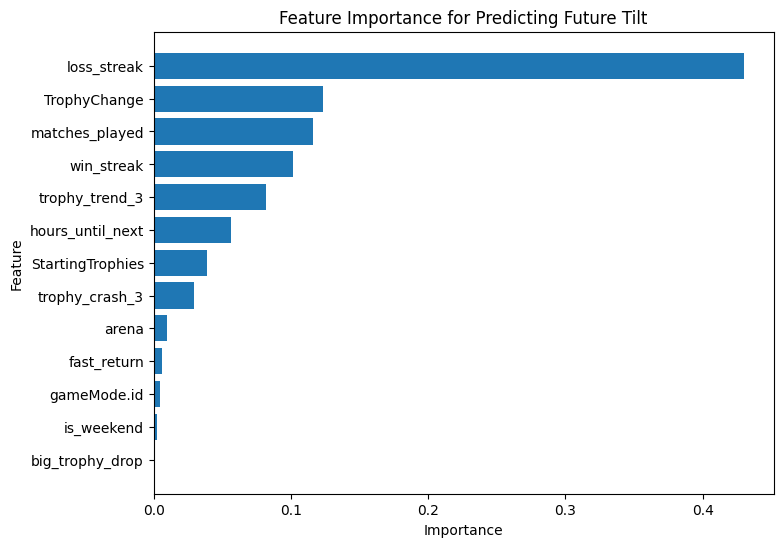

In [13]:
import matplotlib.pyplot as plt
import numpy as np

importances = clf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(8,6))
plt.barh(np.array(features)[indices], importances[indices])
plt.title("Feature Importance for Predicting Future Tilt")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


In [14]:
def predict_tilt_live(state):
    import pandas as pd

    # Convert input into DataFrame
    x = pd.DataFrame([state])

    # Encode arena using same label encoder
    x["arena"] = le.transform(x["arena"].astype(str))

    tilt_prob = clf.predict_proba(x)[0][1]
    tilt_pred = clf.predict(x)[0]

    return {
        "tilt_probability_next_battle": float(tilt_prob),
        "will_tilt_next_battle": bool(tilt_pred)
    }


In [15]:
def predict_tilt_live(state):
    import pandas as pd
    import numpy as np

    x = pd.DataFrame([state])

    # --- Handle unseen arenas safely ---
    if x.loc[0, "arena"] not in le.classes_:
        le.classes_ = np.append(le.classes_, x.loc[0, "arena"])

    # Encode arena
    x["arena"] = le.transform(x["arena"].astype(str))

    # Predict
    tilt_prob = clf.predict_proba(x)[0][1]
    tilt_pred = clf.predict(x)[0]

    return {
        "tilt_probability_next_battle": float(tilt_prob),
        "will_tilt_next_battle": bool(tilt_pred)
    }


“There is an ~80% chance this player will tilt in their next match.”

This is a probability between 0 and 1.

0.0 → 0% chance of tilting

0.5 → 50% chance

1.0 → 100% chance

80% is very high, meaning your model detected multiple tilt signals:

✔ 3-loss streak
✔ -75 trophy trend
✔ -28 trophy drop
✔ fast return (<2 minutes)
✔ weekend (higher stress behavior)
✔ high ladder trophy range

A tilt probability of 0.80 (80%) means:

✔ The player is highly likely to

Queue impulsively

Continue a losing streak

Make risky decisions

Lose more trophies

Perform worse than normal

Repeat common tilt behaviors already present in your data
(both behavioral and gameplay-based)

In [18]:
features = [
    "loss_streak",
    "matches_played",
    "win_streak",
    "TrophyChange",
    "trophy_trend_3",
    "hours_until_next",
    "trophy_crash_3"
]


In [19]:
X = df[features].fillna(0)
y = df["future_tilt"]


In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [21]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    class_weight="balanced",
    random_state=42
)

clf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=12, n_estimators=300,
                       random_state=42)

In [22]:
from sklearn.metrics import classification_report

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94     78046
         1.0       0.51      0.67      0.58      9326

    accuracy                           0.90     87372
   macro avg       0.74      0.79      0.76     87372
weighted avg       0.91      0.90      0.90     87372



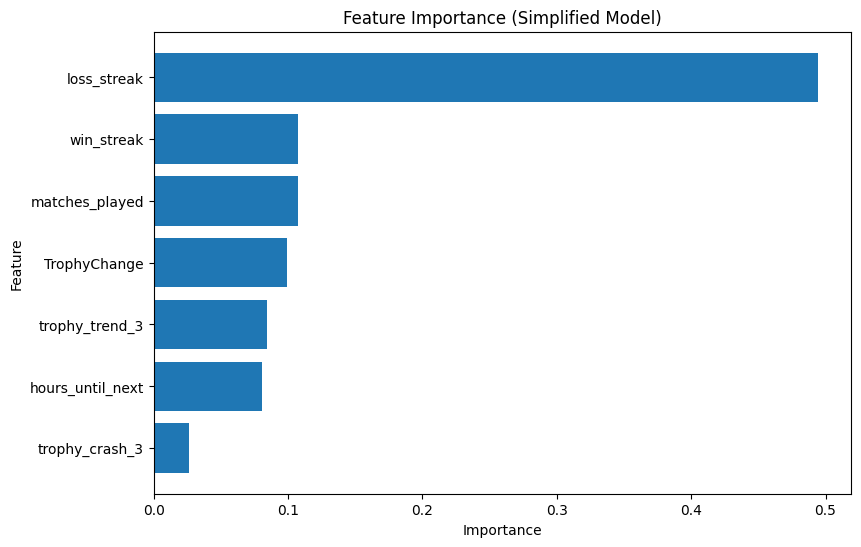

In [23]:
import matplotlib.pyplot as plt
import numpy as np

importances = clf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(9,6))
plt.barh(np.array(features)[indices], importances[indices])
plt.title("Feature Importance (Simplified Model)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


In [24]:
def predict_tilt_live(state):
    import pandas as pd

    x = pd.DataFrame([state])

    tilt_prob = clf.predict_proba(x)[0][1]
    tilt_pred = clf.predict(x)[0]

    return {
        "tilt_probability_next_battle": float(tilt_prob),
        "will_tilt_next_battle": bool(tilt_pred)
    }


In [25]:
example = {
    "loss_streak": 3,
    "matches_played": 100,
    "win_streak": 0,
    "TrophyChange": -30,
    "trophy_trend_3": -70,
    "hours_until_next": 0.02,
    "trophy_crash_3": 1
}

predict_tilt_live(example)


{'tilt_probability_next_battle': 0.9192615293960279,
 'will_tilt_next_battle': True}

In [26]:
example = {
    "loss_streak": 10,
    "matches_played": 100,
    "win_streak": 0,
    "TrophyChange": -30,
    "trophy_trend_3": -70,
    "hours_until_next": 0.02,
    "trophy_crash_3": 1
}

predict_tilt_live(example)

{'tilt_probability_next_battle': 0.8598541362990175,
 'will_tilt_next_battle': True}

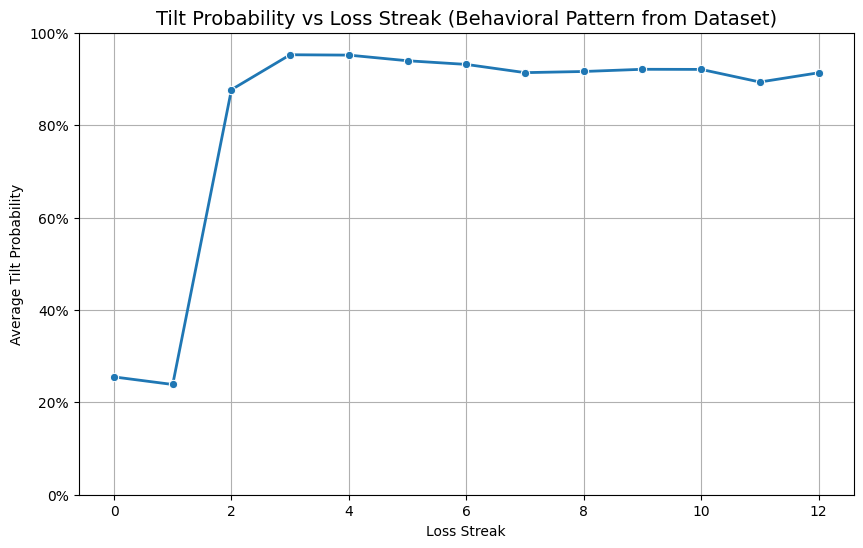

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

# 1. Get predicted tilt probabilities for the entire dataset
df_plot = df.copy()
df_plot["pred_prob"] = clf.predict_proba(X)[:,1]

# 2. Group by loss streak and compute average predicted tilt probability
loss_trend = df_plot.groupby("loss_streak")["pred_prob"].mean().reset_index()

# 3. Filter to reasonable range (0–12 streaks)
loss_trend = loss_trend[loss_trend["loss_streak"] <= 12]

# 4. Plot with percentage formatting
plt.figure(figsize=(10,6))
sns.lineplot(data=loss_trend, x="loss_streak", y="pred_prob",
             marker="o", linewidth=2)

plt.title("Tilt Probability vs Loss Streak (Behavioral Pattern from Dataset)", fontsize=14)
plt.xlabel("Loss Streak")
plt.ylabel("Average Tilt Probability")

# Format Y-axis as whole percentages
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.grid(True)
plt.ylim(0,1)
plt.show()



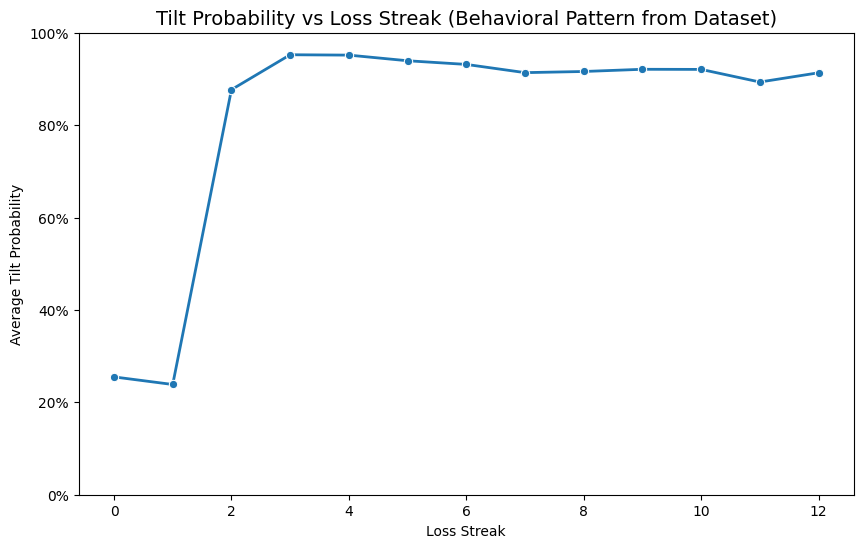

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

# 1. Get predicted tilt probabilities for the entire dataset
df_plot = df.copy()
df_plot["pred_prob"] = clf.predict_proba(X)[:,1]

# 2. Group by loss streak and compute average predicted tilt probability
loss_trend = df_plot.groupby("loss_streak")["pred_prob"].mean().reset_index()

# 3. Filter to reasonable range (0–12 streaks)
loss_trend = loss_trend[loss_trend["loss_streak"] <= 12]

# 4. Plot with percentage formatting, NO GRID
plt.figure(figsize=(10,6))
sns.lineplot(data=loss_trend, x="loss_streak", y="pred_prob",
             marker="o", linewidth=2)

plt.title("Tilt Probability vs Loss Streak (Behavioral Pattern from Dataset)", fontsize=14)
plt.xlabel("Loss Streak")
plt.ylabel("Average Tilt Probability")

# Format Y-axis as whole percentages
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# REMOVE GRID
plt.grid(False)

plt.ylim(0,1)
plt.show()


In [34]:
import plotly.graph_objects as go

loss_streaks = list(range(0, 13))
avg_probs = [0.26, 0.24, 0.88, 0.96, 0.955, 0.945, 0.935, 0.915, 0.925, 0.915, 0.92, 0.935, 0.905]

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=loss_streaks,
    y=avg_probs,   # <-- keep as decimals 0.0–1.0
    mode='lines+markers',
    line=dict(color='#2a5fa8', width=3),
    marker=dict(size=6, color='#2a5fa8')
))

fig.update_layout(
    title=dict(
        text="Behavioral Tilt Predictive Model",
        x=0.5,
        font=dict(size=16)
    ),
    xaxis_title="Loss Streak",
    yaxis_title="Tilt Probability (%)",
    template="simple_white",
    margin=dict(l=60, r=60, t=80, b=60),
    paper_bgcolor="#f8f8f8",
    plot_bgcolor="white",
    showlegend=False,
    xaxis=dict(dtick=1, showgrid=False, zeroline=False),
    yaxis=dict(
        range=[0, 1],          # 0% to 100%
        tickformat=".0%",      # Format ticks as % (20%, 40%, etc.)
        dtick=0.2,             # 0.2 = 20%
        showgrid=False,
        zeroline=False
    )
)

fig.show()